## Third Generation : Sequential Trade Models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from FinancialMachineLearning.features.microstructure import *

data = pd.read_parquet('../../Data/AAPL_tick.parquet')

In [2]:
tick_side = tick_rule(data['Price'])

In [3]:
data['Side'] = tick_side

In [4]:
data_ohlc = data['Price'].resample('1T').ohlc()
data_ohlc['volume'] = data['Volume'].resample('1T').sum()

### Probaility of Informed Trading models

이슬리 등은 거래 데이터를 사용해 개별 증권의 정보 기반 거래 확률을 계산한다. 해당 미시 구조 모델은 거래를 시장 조성자와 포지션을 취하는 거래자 간에 여러 번의 거래 주기에 걸쳐 반복되는 게임으로 봤다

증권의 $S$, 현재 가격을 $S_0$로 표기하자. 특정 양의 새로운 정보가 가격 $S$에 포함되면 $S$는 $S_B$ 또는 $S_G$가 된다. 분석 중인 시간 프레임 내에 새로운 정보가 도달할 확률은 $\alpha$이거, 그 뉴스가 나쁜 뉴스일 확률은 $\delta$, 뉴스가 좋은 뉴스일 확률은 $(1-\delta)$이다. 이 저자들은 시점 $t$에서의 증권 가격 기대값은 다음과 같이 계산할 수 있다는 것을 증명했다

$$E[S_t] = (1-\alpha_t)S_0 + \alpha_t [\delta_tS_B+(1-\delta_t)S_G]$$

정보 기반 거래자들은 푸아송 분포를 따라 $\mu$비율로 등장하고, 잡음 거래자들은 $\epsilon$비율로 등장한다면 시장 조성자들은 정보 기반 거래자로부터의 손실을 피하고자 손익 분기 매수 호가 수준을 $B_t$로 설정한다

$$E[B_t] = E[S_t] - \frac{\mu \alpha_t \delta_t}{\epsilon + \mu \alpha_t \delta_t}(E[S_t] - S_B)$$

그리고 시각 $t$에서의 손익 분기 매도 호가 수준 $A_t$는 다음과 같다

$$E[A_t] = E[S_t] + \frac{\mu \alpha_t (1-\delta_t)}{\epsilon +\mu \alpha_t (1-\delta_t)}(S_G - E[S_t])$$

이에 따라 손익 분기 매매 호가 스프레드는 다음과 같이 결정된다

$$E[A_t - B_t] = \frac{\mu \alpha_t (1-\delta_t)}{\epsilon + \mu \alpha_t (1-\delta_t)}(S_G - E[S_t]) + \frac{\mu \alpha_t \delta_t}{\epsilon + \mu\alpha_t \delta_t}(E[S_t] - S_B)$$

$\delta_t = \frac{1}{2}$인 경우에 다음을 얻게 된다

$$\delta_t = \frac{1}{2} \Rightarrow E[A_t - B_t] = \frac{\alpha_t \mu}{\alpha_t \mu + 2\epsilon}(S_G - S_B)$$

이 식은 시장 조성자들이 유동성을 공급하는 가격의 범위를 결정하는 주요한 요인이 다음과 같다는 것을 말해 준다

$$\mathrm{PIN}_t = \frac{\alpha_t \mu}{\alpha_t \mu + 2\epsilon}$$

첨자 $t$는 확률 $\alpha$와 $\delta$가 그 시점에서 추정됐음을 표시한다. $\mathrm{PIN}_t$값을 결정하려면 네 가지 관측 불가능한 parameter, 즉 $\{\alpha, \delta, \mu, \epsilon\}$ 모두 추정해야 한다. Maximum likelihood Estimation 방법은 세 가지 푸아송 분포의 혼합을 적합화 한다

$$P[V^B, V^S] = (1-\alpha) P[V^B, \epsilon] P[V^S, \epsilon] + \alpha (\delta P[V^B, \epsilon] P[V^S, \mu + \epsilon] + (1-\delta)P[V^B, \mu+\epsilon]P[V^S,\epsilon])$$

여기서 $V^B$는 매도 호가(매수자 개시거래)에 대한 거래량, $V^S$는 매수호가(매도자 개시거래) 거래에 대한 거래량이다.

In [5]:
buy_order = data[data['Side'] == 1]['Price'].resample('1T').ohlc()
sell_order = data[data['Side'] == -1]['Price'].resample('1T').ohlc()
buy_order['volume'] = data[data['Side'] == 1]['Volume'].resample('1T').sum()
sell_order['volume'] = data[data['Side'] == -1]['Volume'].resample('1T').sum()

In [6]:
pin = probability_of_informed_trading(
    buy_orders = buy_order['volume'],
    sell_orders = sell_order['volume']
)

  1%|          | 1828/247945 [00:09<42:50, 95.76it/s] /Users/tommylee/Desktop/Pycharm/MLFinance/FinancialMachineLearning/features/microstructure.py:433: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(buy_orders * np.log(pi_buy) + sell_orders * np.log(pi_sell))
100%|██████████| 247945/247945 [12:35<00:00, 328.11it/s]


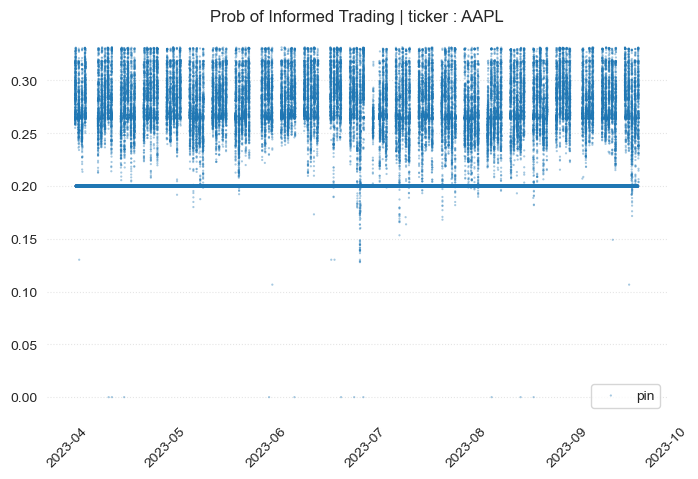

In [11]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    buy_order.index[20:], 
    pin.values,
    marker = '.',
    edgecolor = 'none',
    alpha = 0.4,
    s = 10,
    label = r"pin"
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.legend()
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xticks(rotation = 45)
plt.title(r'Prob of Informed Trading | ticker : AAPL')
plt.show()

### Volume-Synchronized Probability of Informed Trading

Easly(2008) 등은 다음을 증명했다.

$$E\left[V^B - V^S\right] = (1 - \alpha)(\epsilon - \epsilon) + \alpha (1 - \delta) (\epsilon - (\mu + \epsilon)) + \alpha \delta(\mu + \epsilon - \epsilon) = \alpha \mu(1 - 2\delta)$$

그리고 특히, 충분히 큰 $\mu$에 대해 다음이 성립한다는 것을 보였다.

$$E \left[ \vert V^B - V^S \vert\right] \approx \alpha \mu$$

Easly(2011)등은 PIN의 고빈도 추정치를 제시했는데, 이를 정보 기반 거래의 거래량 동기화 확률이라고 불렀다. 이 절차는 거래량 기준 바를 채택하는데, 데이터 샘플링을 거래량에 의해 포착된 시장활동과 동기화한다. 이를 통해 다음을 추정할 수 있다.

$$\frac{1}{N} \sum_{\tau = 1}^n \vert V_{\tau}^B - V_{\tau}^S \vert \approx \alpha \mu$$

여기서 $V_{\tau}^B$는 거래량 바 $\tau$ 내의 매수 개시 거래로부터 거래된 거래량의 합, $V_{\tau}^S$는 거래량 바 $\tau$ 내의 매도 개시로부터 거래된 거래량 합이다. $N$은 계산을 위해 사용된 바의 개수다. 모든 거래량 바는 동일한 크기 $V$이므로 설정상 우리는 다음과 같다는 것을 알고 있다.

$$\frac{1}{n} \sum_{\tau = 1}^n \left( V_{\tau}^B + V_{\tau}^S \right) = V = \alpha \mu + 2 \epsilon$$

따라서 PIN은 고빈도에서 다음과 같이 추정될 수 있다.

$$\mathrm{VPIN}_{\tau} = \frac{
\sum_{\tau = 1}^n \vert V_{\tau}^B - V_{\tau}^S\vert
}{
\sum_{\tau=1}^n (V_{\tau}^B + V_{\tau}^S)
} = \frac{\sum_{\tau=1}^n \vert V_{\tau}^B - V_{\tau}^S\vert}{nV}$$